##Matt Lawder

In [20]:
import pandas as pd
import numpy as np
import sqlite3
import re
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sns
import datetime

In [3]:
LMPs=pd.read_csv("2011_JUL_SEP_RT_LMP.CSV")

##Eplaination of Data
This dataset comes form the Midcontinent Independent System Operator (MISO) Regional Transmission Organization.
(https://www.misoenergy.org/Pages/Home.aspx)
Basically this entity is the public market place where energy is bought and sold in real-time between Large Scale Generators, Electric Utilities, Electric Co-ops, and any other large entity that wishes to purchase or generate power.

Prices for a MWh of energy flucuate both temporally and geogrpahically. To get the price the at given location, we start with the base set price from MISO. MISO sets a base price (for a given time) that is the same across the entire region. Then at each point a Marginal Loss Cost (MLC) is subtracted from the value. The MLC is based on the physical loss locaaly at the node point and does not flucuate much throughout MISO. Then a Marginal Congestion Cost (MCC) is subtracted (or added if it's negative) to the base price. This final value is the Location Marginal Price (LMP).

LMP=Base Price-MLC-MCC

The MCC is based on a combination of factors and can vary greatly between points. Estenially the MCC accounts for the cost of trnasmiting energy from where it is generated to where it is demanded. For locations that have lots of generation and low demand the MCC will be high, driving down the price of energy (and sometimes making it negative). THis can occur in places like Iowa that may be generating lots of energy from wind power overnight, but do not have sufficient transmission to send the energy where it is demanded. The opposite case can also occur. High demand and low generation will drive prices up.

Below is a table of all the Node points in the MISO region between 7/1/2011 and 9/30/2011 (the full dataset will include data up to the end of 2015).

Market_Day       =Date

Node             =Name of Node point for pricing

Type             =Is the node a generator, user, or other

Value            =LMP, MLC, or MCC

HE01, HE02, etc  =Hour of the Day

In [4]:
LMPs

,MARKET_DAY,NODE,TYPE,VALUE,HE01,HE02,HE03,HE04,HE05,HE06,...,HE15,HE16,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24
0,7/1/2011,AEC,Interface,LMP,21.85,23.42,17.05,18.19,19.82,22.38,...,36.38,30.33,29.77,26.88,25.67,24.12,23.42,26.35,23.78,22.31
1,7/1/2011,AEC,Interface,MCC,0.13,8.69,-0.15,-0.05,2.15,3.38,...,-2.97,-0.23,-0.31,-0.47,0.13,-0.07,-0.05,-0.24,-0.15,0.00
2,7/1/2011,AEC,Interface,MLC,-0.37,-0.27,-0.34,-0.43,-0.39,-0.55,...,-1.28,-1.06,-1.16,-1.16,-1.08,-0.81,-0.72,-0.76,-0.73,-0.49
3,7/1/2011,AECI,Interface,LMP,18.41,18.70,15.43,17.54,18.62,20.99,...,37.13,30.43,29.92,24.99,24.74,23.76,23.11,25.40,23.52,21.92
4,7/1/2011,AECI,Interface,MCC,-2.73,4.40,-1.28,-0.26,1.37,2.40,...,-2.65,-0.23,-0.31,-2.38,-0.71,-0.21,-0.05,-0.87,-0.15,0.00
5,7/1/2011,AECI,Interface,MLC,-0.95,-0.70,-0.82,-0.87,-0.82,-0.96,...,-0.85,-0.97,-1.01,-1.14,-1.18,-1.03,-1.03,-1.08,-1.00,-0.88
6,7/1/2011,AECI.ALTW,Loadzone,LMP,19.02,17.41,16.06,18.05,18.53,20.92,...,39.19,32.04,31.53,27.23,26.79,25.07,24.21,26.19,24.55,22.60
7,7/1/2011,AECI.ALTW,Loadzone,MCC,-2.50,2.84,-1.03,-0.19,0.80,1.71,...,-2.60,-0.23,-0.31,-1.65,-0.11,-0.17,-0.05,-1.33,-0.15,0.00
8,7/1/2011,AECI.ALTW,Loadzone,MLC,-0.57,-0.44,-0.45,-0.44,-0.33,-0.34,...,1.16,0.64,0.60,0.38,0.28,0.23,0.06,0.17,0.03,-0.20
9,7/1/2011,AECI.AMMO,Loadzone,LMP,21.56,21.18,16.92,18.09,19.18,21.42,...,37.12,30.81,30.31,27.40,26.09,24.44,23.60,26.39,23.84,22.26


Converting the Date into proper format

In [21]:
datechange=pd.to_datetime(LMPs['MARKET_DAY'])

In [22]:
LMPs['MARKET_DAY']=datechange

In [23]:
LMPs

,MARKET_DAY,NODE,TYPE,VALUE,HE01,HE02,HE03,HE04,HE05,HE06,...,HE15,HE16,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24
0,2011-07-01,AEC,Interface,LMP,21.85,23.42,17.05,18.19,19.82,22.38,...,36.38,30.33,29.77,26.88,25.67,24.12,23.42,26.35,23.78,22.31
1,2011-07-01,AEC,Interface,MCC,0.13,8.69,-0.15,-0.05,2.15,3.38,...,-2.97,-0.23,-0.31,-0.47,0.13,-0.07,-0.05,-0.24,-0.15,0.00
2,2011-07-01,AEC,Interface,MLC,-0.37,-0.27,-0.34,-0.43,-0.39,-0.55,...,-1.28,-1.06,-1.16,-1.16,-1.08,-0.81,-0.72,-0.76,-0.73,-0.49
3,2011-07-01,AECI,Interface,LMP,18.41,18.70,15.43,17.54,18.62,20.99,...,37.13,30.43,29.92,24.99,24.74,23.76,23.11,25.40,23.52,21.92
4,2011-07-01,AECI,Interface,MCC,-2.73,4.40,-1.28,-0.26,1.37,2.40,...,-2.65,-0.23,-0.31,-2.38,-0.71,-0.21,-0.05,-0.87,-0.15,0.00
5,2011-07-01,AECI,Interface,MLC,-0.95,-0.70,-0.82,-0.87,-0.82,-0.96,...,-0.85,-0.97,-1.01,-1.14,-1.18,-1.03,-1.03,-1.08,-1.00,-0.88
6,2011-07-01,AECI.ALTW,Loadzone,LMP,19.02,17.41,16.06,18.05,18.53,20.92,...,39.19,32.04,31.53,27.23,26.79,25.07,24.21,26.19,24.55,22.60
7,2011-07-01,AECI.ALTW,Loadzone,MCC,-2.50,2.84,-1.03,-0.19,0.80,1.71,...,-2.60,-0.23,-0.31,-1.65,-0.11,-0.17,-0.05,-1.33,-0.15,0.00
8,2011-07-01,AECI.ALTW,Loadzone,MLC,-0.57,-0.44,-0.45,-0.44,-0.33,-0.34,...,1.16,0.64,0.60,0.38,0.28,0.23,0.06,0.17,0.03,-0.20
9,2011-07-01,AECI.AMMO,Loadzone,LMP,21.56,21.18,16.92,18.09,19.18,21.42,...,37.12,30.81,30.31,27.40,26.09,24.44,23.60,26.39,23.84,22.26


Old method for moving to SQL

In [ ]:
#LMPs_tosql=pd.DataFrame({'MARKET_DAY':[],'NODE':[],'TYPE':[],'VALUE':[],'PRICE':[]})
#xj=0
#arrlmps=np.array(FLMPs)
#for j in arrlmps:
#    for i  in range(24):
#        A = np.append(np.append(arrlmps[xj][0]+np.timedelta64(i+1,'h'), arrlmps[xj][1:4]) , arrlmps[xj][4+i])
#        B=pd.DataFrame({'MARKET_DAY':[A[0]],'NODE':[A[1]],'TYPE':[A[2]],'VALUE':[A[3]],'PRICE':[A[4]]},index=[xj*24+i])
#        LMPs_tosql=pd.concat([LMPs_tosql,B])
#    xj=xj+1

###Moving the data in SQL database for ease of access
Switching the hour value to be individual records

In [5]:
conn=sqlite3.connect('miso_lmp_data.db')

In [6]:
LMPs.to_sql('temph1',conn, if_exists='replace')

In [16]:
LMPs_final=pd.DataFrame({'MARKET_DAY':[],'NODE':[],'TYPE':[],'VALUE':[],'HOUR':[],'PRICE':[]})
LMPs_final.to_sql('LMPdata',conn,if_exists='fail')

In [ ]:
for i in range(24):
    if i<9:
        LMPsh1=pd.read_sql('SELECT MARKET_DAY, NODE, TYPE, VALUE, HE0'+str(i+1)+' FROM temph1',conn)
    else:
        LMPsh1=pd.read_sql('SELECT MARKET_DAY, NODE, TYPE, VALUE, HE'+str(i+1)+' FROM temph1',conn)
    LMPsh1.columns=['MARKET_DAY','NODE','TYPE','VALUE','PRICE']
    LMPsh1['HOUR']=i+1
    LMPsh1.to_sql('LMPdata',conn,if_exists='append')
    #LMPs_final=pd.concat([LMPs_final,LMPsh1])

In [1]:
#LMPs_final.to_sql('LMPdata',conn)

In [7]:
pd.read_sql('SELECT * FROM LMPdata WHERE HOUR=1',conn)

,index,HOUR,MARKET_DAY,NODE,PRICE,TYPE,VALUE
0,0,1,2011-07-01 00:00:00,AEC,21.85,Interface,LMP
1,1,1,2011-07-01 00:00:00,AEC,0.13,Interface,MCC
2,2,1,2011-07-01 00:00:00,AEC,-0.37,Interface,MLC
3,3,1,2011-07-01 00:00:00,AECI,18.41,Interface,LMP
4,4,1,2011-07-01 00:00:00,AECI,-2.73,Interface,MCC
5,5,1,2011-07-01 00:00:00,AECI,-0.95,Interface,MLC
6,6,1,2011-07-01 00:00:00,AECI.ALTW,19.02,Loadzone,LMP
7,7,1,2011-07-01 00:00:00,AECI.ALTW,-2.50,Loadzone,MCC
8,8,1,2011-07-01 00:00:00,AECI.ALTW,-0.57,Loadzone,MLC
9,9,1,2011-07-01 00:00:00,AECI.AMMO,21.56,Loadzone,LMP


In [9]:
pd.read_sql('SELECT * FROM LMPdata WHERE HOUR=24',conn)

,index,HOUR,MARKET_DAY,NODE,PRICE,TYPE,VALUE
0,0,24,2011-07-01 00:00:00,AEC,22.31,Interface,LMP
1,1,24,2011-07-01 00:00:00,AEC,0.00,Interface,MCC
2,2,24,2011-07-01 00:00:00,AEC,-0.49,Interface,MLC
3,3,24,2011-07-01 00:00:00,AECI,21.92,Interface,LMP
4,4,24,2011-07-01 00:00:00,AECI,0.00,Interface,MCC
5,5,24,2011-07-01 00:00:00,AECI,-0.88,Interface,MLC
6,6,24,2011-07-01 00:00:00,AECI.ALTW,22.60,Loadzone,LMP
7,7,24,2011-07-01 00:00:00,AECI.ALTW,0.00,Loadzone,MCC
8,8,24,2011-07-01 00:00:00,AECI.ALTW,-0.20,Loadzone,MLC
9,9,24,2011-07-01 00:00:00,AECI.AMMO,22.26,Loadzone,LMP


In [13]:
AECdata=pd.read_sql('SELECT * FROM LMPdata WHERE NODE="AEC" AND VALUE="LMP"',conn)

Plotting one set of values (need to account for indivdual hour affects)

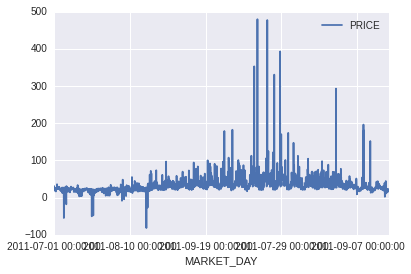

In [26]:
AECdata.plot(x='MARKET_DAY',y='PRICE')

##Goals of Project
With the data properly formatted into SQL, we can begin to allow query searches for how the prices change over multiple years. For most utilities or customers who are purchasing power, they will lock in at long term fixed rates. They will have to buy the power at the price and sell it into the grid at the market price (unless they are local to the generation). The difference in their fixed price will determine if they make money or lose money each hour of the day.

Questions to be answered:

If an organization locks in a fixed power price from a single generator when will they make profit from that power and when will they lose money?

If an organization sells power into the grid at the generation site and buys out at it's local node. What is the difference between those points? This value account for average "Transmission" costs. 